In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
data_path = '/content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN/E_to_E_CNN_MV_DWI'
sys.path.insert(0,data_path)

In [3]:
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Add, Subtract, Lambda, LayerNormalization,\
    LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D, \
    Conv2DTranspose, Dropout, Concatenate,concatenate, SeparableConv2D, PReLU
from tensorflow.keras.models import Model
# Deep learning packages
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
import numpy as np
import matplotlib.pyplot as plt
import time, pdb, os
import scipy.io as sio
import glob

In [4]:
## RU-Net
def batchnorm_relu(inputs):
     """ Batch Normalization & ReLU """
     x = BatchNormalization()(inputs)
     x = Activation("relu")(x)
     x = Dropout(0.05)(x)#0.05
     return x

def residual_block(inputs, num_filters, strides=1):
     """ Convolutional Layers """
     x = batchnorm_relu(inputs)
     x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)
     x = batchnorm_relu(x)
     x = Conv2D(num_filters, 3, padding="same", strides=1)(x)
     """ Shortcut Connection (Identity Mapping) """
     s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)
     """ Addition """
     x = x + s
     return x

def decoder_block(inputs, skip_features, num_filters):
     """ Decoder Block """
     x = UpSampling2D((2, 2))(inputs) 
     x = Concatenate()([x, skip_features]) 
     x = residual_block(x, num_filters, strides=1) 
     return x

def build_resunet(input_shape,sc):
     """ RESUNET Architecture """
    
     inputs = Input(input_shape)

     """ Endoder 1 """ 
     x = Conv2D(64*sc, 3, padding="same", strides=1)(inputs) 
     x = batchnorm_relu(x) 
     x = Conv2D(64*sc, 3, padding="same", strides=1)(x) 
     s = Conv2D(64*sc, 1, padding="same")(inputs) 
     s1 = x + s

     """ Encoder 2, 3 """
     s2 = residual_block(s1, 128*sc, strides=2)
     s3 = residual_block(s2, 256*sc, strides=2)

     """ Bridge """
     b = residual_block(s3, 512*sc, strides=2)

     """ Decoder 1, 2, 3 """ 
     x = decoder_block(b, s3, 256*sc) 
     x = decoder_block(x, s2, 128*sc) 
     x = decoder_block(x, s1, 64*sc)

     """ Classifier """
     outputs = Conv2D(1, 1, padding="same", activation=None)(x)

     """ Model """
     model = Model(inputs, outputs, name="RESUNET")

     return model

In [5]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, filename_list,num_rows, num_cols,batch_size,
                 shuffle=True):

        self.filename_list = filename_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(self.filename_list)
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            #Shuffle the filename list in-place
            np.random.shuffle(self.filename_list)

    def __get_data(self, filenames):

        noise_img = np.empty((self.batch_size,self.num_rows,self.num_cols,1))
        label_img = np.empty((self.batch_size,self.num_rows,self.num_cols,1))
        
        for idx, curr_filename in enumerate(filenames):
            noise_img[idx,], label_img[idx,] = self.prepare_single_input_output_pair(curr_filename)
        return noise_img, label_img

    # Return the index'th batch
    def __getitem__(self, index):
        curr_filenames = self.filename_list[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(curr_filenames)

        return X, y

    def __len__(self):
        return self.num_samples // self.batch_size

    def prepare_single_input_output_pair(self,filename_one_sample):
        temp = sio.loadmat(filename_one_sample)
        noise_img = temp['ImL']
        noise_img = noise_img/np.max(noise_img)
        noise_img = tf.expand_dims(noise_img,axis=-1)
        label_img = temp['Label']
        label_img = label_img/np.max(label_img)
        label_img = tf.expand_dims(label_img,axis=-1)
     
        return noise_img, label_img

In [6]:
num_rows = 128
num_cols = 128
num_batchs = 8

input_paths = glob.glob(os.path.join(data_path, "Train_Int/*.mat"))
decode = tf.image.decode_png

if len(input_paths) == 0:
    raise Exception("input_dir contains no image files")

def get_name(path):
    name, _ = os.path.splitext(os.path.basename(path))
    return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
if all(get_name(path).isdigit() for path in input_paths):
    input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
else:
    input_paths = sorted(input_paths)

training_gen = DataGenerator(input_paths,num_rows, num_cols,num_batchs,shuffle=True)
#######################################################################################################################
input_paths = glob.glob(os.path.join(data_path, "Validate_Int/*.mat"))
decode = tf.image.decode_png

if len(input_paths) == 0:
    raise Exception("input_dir contains no image files")

def get_name(path):
    name, _ = os.path.splitext(os.path.basename(path))
    return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
if all(get_name(path).isdigit() for path in input_paths):
    input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
else:
    input_paths = sorted(input_paths)

val_gen = DataGenerator(input_paths,num_rows, num_cols, num_batchs, shuffle=True)

# The model for 8M trainable parameters

In [ ]:
# "Important" parameters
num_epochs = 200
loss = 'nrmse'
learning_rate_base = 1e-4
batch_size = num_batchs


tensorboard_filepath = os.path.join(data_path,'results')
model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'Res_UNet.h5')#1>64>depth=5 #2>128>depth=5
pretrained_inet_path = os.path.join(data_path,'trained_weights', 'Res_UNet.h5')

model = build_resunet(input_shape=(num_rows,num_cols,1),sc=1)

if pretrained_inet_path is not None:
   model.load_weights(pretrained_inet_path)

# Compile the model
adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
tbCallBack = TensorBoard(log_dir=tensorboard_filepath, histogram_freq=0, write_graph=False, write_images=False)
checkpointerCallBack = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

if loss == 'nrmse':
    # Objective function
    def my_objective_function(y_true, y_pred):
        return 100 * K.sqrt(K.sum(K.square(y_pred - y_true))) / K.sqrt(K.sum(K.square(y_true)))

    model.compile(loss=my_objective_function, optimizer=adam_opt)
else:
    model.compile(loss=loss, optimizer=adam_opt)  

# The model for 32M trainable parameters

In [7]:
# "Important" parameters
num_epochs = 200
loss = 'nrmse'
learning_rate_base = 1e-4
batch_size = num_batchs


tensorboard_filepath = os.path.join(data_path,'results')
model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'Res_UNet_128V2.h5')#1>64>depth=5 #2>128>depth=5
pretrained_inet_path = os.path.join(data_path,'trained_weights', 'Res_UNet_128V2.h5')

model = build_resunet(input_shape=(num_rows,num_cols,1),sc=2)

if pretrained_inet_path is not None:
   model.load_weights(pretrained_inet_path)

# Compile the model
adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
tbCallBack = TensorBoard(log_dir=tensorboard_filepath, histogram_freq=0, write_graph=False, write_images=False)
checkpointerCallBack = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

if loss == 'nrmse':
    # Objective function
    def my_objective_function(y_true, y_pred):
        return 100 * K.sqrt(K.sum(K.square(y_pred - y_true))) / K.sqrt(K.sum(K.square(y_true)))

    model.compile(loss=my_objective_function, optimizer=adam_opt)
else:
    model.compile(loss=loss, optimizer=adam_opt)   



# The model for 73M trainable parameters


In [ ]:
# "Important" parameters
num_epochs = 200
loss = 'nrmse'
learning_rate_base = 1e-4
batch_size = num_batchs


tensorboard_filepath = os.path.join(data_path,'results')
model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'Res_UNet_256.h5')#1>64>depth=5 #2>128>depth=5
pretrained_inet_path = os.path.join(data_path,'trained_weights', 'Res_UNet_256.h5')

model = build_resunet(input_shape=(num_rows,num_cols,1),sc=4)

if pretrained_inet_path is not None:
   model.load_weights(pretrained_inet_path)

# Compile the model
adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
tbCallBack = TensorBoard(log_dir=tensorboard_filepath, histogram_freq=0, write_graph=False, write_images=False)
checkpointerCallBack = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

if loss == 'nrmse':
    # Objective function
    def my_objective_function(y_true, y_pred):
        return 100 * K.sqrt(K.sum(K.square(y_pred - y_true))) / K.sqrt(K.sum(K.square(y_true)))

    model.compile(loss=my_objective_function, optimizer=adam_opt)
else:
    model.compile(loss=loss, optimizer=adam_opt) 

In [ ]:
!nvidia-smi

In [ ]:
model.summary()

In [ ]:
hist = model.fit(x=training_gen, 
                     epochs=num_epochs, 
                     verbose=2, 
                     callbacks=[tbCallBack,checkpointerCallBack], 
                     validation_data=val_gen, 
                     shuffle=True, 
                     initial_epoch=0)

In [10]:
input_paths = glob.glob(os.path.join(data_path, "Test_EtoE_Case_9/*.mat"))

In [ ]:
input_paths[0]

'/content/gdrive/MyDrive/Deep_Learning_UTEN/TFKB_NUFFT_MV_DWI_CNN/E_to_E_CNN_MV_DWI/Test_EtoE_Case_9/Case9_1.mat'

In [11]:

        ImL = []
        ImR = []
        for idx in range(len(input_paths)):
          fn = glob.glob(os.path.join(data_path, ("Test_EtoE_Case_9/Case9_" +str(idx+1) +".mat")))
          #temp = sio.loadmat(input_paths[idx])
          temp = sio.loadmat(fn[0])
          noise_img = temp['ImL']
          label_img = temp['Label']

          ImL.append(noise_img)
          ImR.append(label_img)
        
        ImL = tf.stack(ImL,axis=0)
        ImR = tf.stack(ImR,axis=0)

In [18]:
t = time.time()
recon = model.predict(tf.expand_dims(ImL,axis=-1))
elapsed = time.time() - t
elapsed/54

2/2 [==============================] - 1s 516ms/step


0.017408048665082013

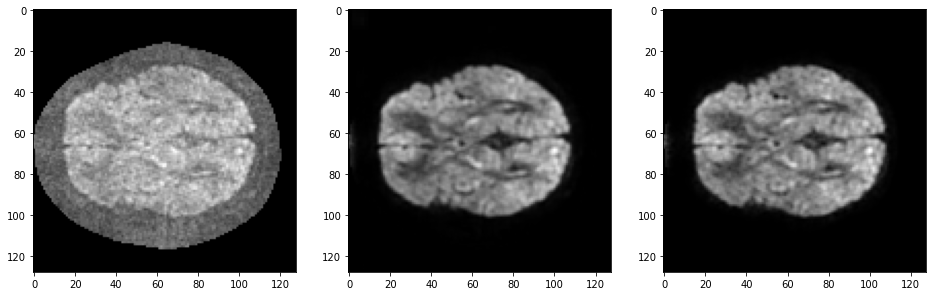

In [14]:
sl = 25
plt.figure(figsize=(16, 16)) 
plt.subplot(1,3,1)
plt.imshow(np.abs(ImL[sl,:,:]))
plt.gray()

plt.subplot(1,3,2)
plt.imshow(np.abs(recon[sl,:,:,0]))
plt.gray()

plt.subplot(1,3,3)
plt.imshow(np.abs(ImR[sl,:,:]))
plt.gray()

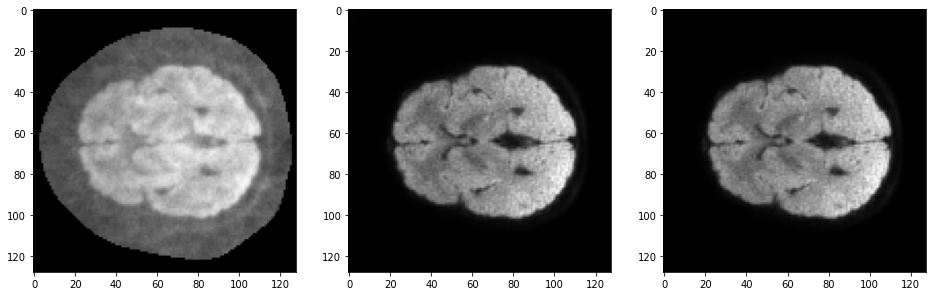

In [ ]:
sl = 0+3*8
plt.figure(figsize=(16, 16)) 
plt.subplot(1,3,1)
plt.imshow(np.abs(ImL[sl,:,:])+np.abs(ImL[sl+1,:,:])+np.abs(ImL[sl+2,:,:]))
plt.gray()

plt.subplot(1,3,2)
plt.imshow(np.abs(recon[sl,:,:,0])+np.abs(recon[sl+1,:,:,0])+np.abs(recon[sl+2,:,:,0]))
plt.gray()

plt.subplot(1,3,3)
plt.imshow(np.abs(ImR[sl,:,:])+np.abs(ImR[sl+1,:,:])+np.abs(ImR[sl+2,:,:]))
plt.gray()

In [15]:
sio.savemat(os.path.join(data_path, 'results/cnn_test_case9.mat'),{'recon':np.array(recon)})

In [ ]:
sio.savemat(os.path.join(data_path, 'results/runet_8m.mat'),{'recon':np.array(recon)})

In [ ]:
nrmse1 = np.array(my_objective_function(np.array(ImR), np.array(tf.squeeze(recon))))
print(nrmse1)
nrmse2 = np.array(my_objective_function(np.array(ImR), np.array(ImL)))
print(nrmse2)

1.0840468879871694
84.63419743035084


In [ ]:
sl = 3
nrmse1 = np.array(my_objective_function(np.array(ImR[sl,:,:]), np.array(tf.squeeze(recon[sl,:,:,:]))))
print(nrmse1)
nrmse2 = np.array(my_objective_function(np.array(ImR), np.array(ImL)))
print(nrmse2)

1.7427966288767949
85.14017287605625


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)